In [1]:
from __future__ import print_function, division
from functools import partial
from collections import Counter, OrderedDict
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, WeightedRandomSampler, DataLoader, SubsetRandomSampler
from torchmetrics.classification import BinaryConfusionMatrix, BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryAccuracy


import time
import os
import torch
import torchvision
import copy
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import StratifiedKFold, KFold

import pandas as pd


cudnn.benchmark = True
plt.ion()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda:0


In [3]:
IMAGES = "../data/MergeModel_Dataset/"
IMAGES_PROCESS = "/content/drive/MyDrive/HPTU_FINAL_DATASET_FILTER_BALANCE"
VALIDATION_IMAGES = "../data/VALIDATION"
RESULTS = './tests/try_2/'



In [4]:
def class_weights_process(train_classes):
    class_count = Counter(train_classes)
    class_weights = torch.Tensor(
        [len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
    return class_weights


def get_loader_complete(path, balanced, batch_size, input_size=224):
    transforms_data = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path, transforms_data)
    train_dataset, test_dataset = random_split(
        dataset, [math.floor(len(dataset) * 0.7), math.ceil(len(dataset)*0.3)])
    print(f'Use balancer dataset: {balanced}')
    
    if balanced:
        train_classes = [label for _, label in train_dataset]
        class_weights = class_weights_process(train_classes)
        sample_weights = [0] * len(train_dataset)
        for idx, (image, label) in enumerate(train_dataset):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(train_dataset), replacement=True)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, sampler=sampler)
        
        
    else:
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    test_dataloader = DataLoader(
        test_dataset, batch_size=round(batch_size))

    image_datasets = {}
    image_datasets['train'] = train_dataset
    image_datasets['test'] = test_dataset

    dataloaders = {}
    dataloaders['train'] = train_dataloader
    dataloaders['test'] = test_dataloader

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    class_names = dataset.classes

    return image_datasets, dataloaders, dataset_sizes, class_names

def get_complete_dateset(path, balanced, batch_size, input_size=224):
    transforms_data = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225])
    ])
    dataset = datasets.ImageFolder(path, transforms_data)
    labels = [label for _, label in dataset]
    
    data = {}
    data['dataset'] = dataset
    data['labels'] = labels
    
    dataset_sizes = len(dataset)
    return data, dataset_sizes
    

def train_kfold(model, criterion, optimizer, scheduler, dataset, dataset_sizes, batch_size, path, name, is_inception=False, num_epochs=25):
    
   
    data = dataset['dataset']
    labels = dataset['labels']

    #splits = KFold(n_splits=5, shuffle=True)
    splits = StratifiedKFold(n_splits=5, shuffle=True)
    foldperf = {}
    
    for fold, (train_index, val_index) in enumerate(splits.split(data, labels)):
        
        print(f'Fold {fold+1}')
        
        train_sampler = SubsetRandomSampler(train_index)
        test_sampler = SubsetRandomSampler(val_index)
        train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler)
        test_loader = DataLoader(data, batch_size=batch_size, sampler=test_sampler)
        
        
        dataloaders = {}
        dataloaders['train'] = train_loader
        dataloaders['test'] = test_loader
    

        train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, path, name, is_inception, num_epochs, fold)



def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, path, name, is_inception=False, num_epochs=25, fold=1):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    epoch_list = []
    train_f1_score = BinaryF1Score().to(device)
    test_f1_score = BinaryF1Score().to(device)
    train_presicion = BinaryPrecision().to(device)
    test_presicion = BinaryPrecision().to(device)
    trian_recall = BinaryRecall().to(device)
    test_recall = BinaryRecall().to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            #total = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #datase_size = len(inputs)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    if phase == 'train':
                        result_f1 = train_f1_score(preds, labels)
                        result_recall = trian_recall(preds, labels)
                        result_presicion = train_presicion(preds, labels)
                    else:
                        result_f1 = test_f1_score(preds, labels)
                        result_recall = test_recall(preds, labels)
                        result_presicion = test_presicion(preds,labels)
    
                

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                #running_loss += loss.item()
                #running_corrects += (preds == labels).sum().item()
                #total += labels.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            #epoch_loss = running_loss / len(dataloaders[phase])
            #epoch_acc = 100 * running_corrects / total

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}%')
            if phase == 'train':
                print(f'{phase} Recall: {result_recall}')
                print(f'{phase} F1 Score: {result_f1}')
                print(f'{phase} Presicion: {result_presicion}')
                        
            else:
                print(f'{phase} Recall: {result_recall}')
                print(f'{phase} F1 Score: {result_f1}')
                print(f'{phase} Presicion: {result_presicion}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc.cpu().data.numpy())
                
                #train_accuracy.append(epoch_acc)
                
                epoch_list.append(epoch)
            else:
                test_accuracy.append(epoch_acc.cpu().data.numpy())
                
                #test_accuracy.append(epoch_acc)
                
                test_loss.append(epoch_loss)

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    #torch.save(model.state_dict(), f'{path}{name}_fold_{fold}.pth')
    torch.save(model.state_dict(), f'{path}_fold_{fold}.pth')
    df = pd.DataFrame([epoch_list, train_accuracy,
                       test_accuracy, train_loss, test_loss])
    df = df.transpose()
    df.columns = ['epoch_list', 'train_accuracy',
                  'test_accuracy', 'train_loss',  'test_loss']
    #df.to_excel(f'{path}{name}_fold_{fold}.xlsx')
    df.to_excel(f'{path}_fold_{fold}.xlsx')

    plot_metrics(epoch_list, train_accuracy, test_accuracy, 'Accuracy')
    plot_metrics(epoch_list, train_loss, test_loss, 'Loss')

    return


def plot_metrics(epochs, train, test, name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train,
                             mode='lines+markers',
                             name='Train'))
    fig.add_trace(go.Scatter(x=epochs, y=test,
                             mode='lines+markers',
                             name='Test'))
    fig.update_layout(title=name,
                      xaxis_title='Epoch',
                      yaxis_title=name,
                      width=700,
                      height=300)
    fig.show()


def visualize_model(model, model_name, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            if model_name == 'inception':
                outputs, aux_outputs = model(inputs)
            else:
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(input, title=None):
    plt.figure()
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    fig = px.imshow(input, title=str(title))
    fig.show()


def plot_images(dataloader, class_names, num_images=4):
    iterator = iter(dataloader)
    inputs, classes = next(iterator)
    out = torchvision.utils.make_grid(inputs[:num_images])
    imshow(out, title=[class_names[x] for x in classes[:num_images]])


def set_models(model_name, path, type_name, feture_extract=False, train=True, kfold=False):
    if model_name == 'densenet':
        model = models.densenet121(weights='DenseNet121_Weights.DEFAULT' if params_base.weights else None)
        feature_extractor(model, feture_extract)
        num_features = model.classifier.in_features

    elif model_name == 'resnet_18' or 'resnet_18' in model_name:
        model = models.resnet18(weights='ResNet18_Weights.DEFAULT' if params_base.weights else None)
        feature_extractor(model, feture_extract)
        num_features = model.fc.in_features

    elif model_name == 'resnet_101':
        model = models.resnet101(weights='ResNet101_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features = model.fc.in_features

    elif model_name == 'resnet_152':
        model = models.resnet152(weights='ResNet152_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features = model.fc.in_features

    elif model_name == 'VGG16':
        model = models.vgg16(weights='VGG16_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features = model.classifier[6].in_features

    elif model_name == 'alexnet':
        model = models.alexnet(weights='AlexNet_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features = model.classifier[6].in_features

    elif model_name == 'inception':
        model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features_aux = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_features_aux, 2)
        num_features = model.fc.in_features

    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features = model.classifier[1].in_features

    elif model_name == 'squeezenet':
        model = models.squeezenet1_0(weights='SqueezeNet1_0_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)

    elif model_name == 'VGG19':
        model = models.vgg19(weights='VGG19_Weights.DEFAULT' if params_base.weights else None)
        model = feature_extractor(model, feture_extract)
        num_features = model.classifier[6].in_features

    
    #Last layer stuff
    if model_name == 'VGG16' or model_name == 'alexnet' or model_name == 'mobilenet' or model_name == 'VGG19':
        features = list(model.classifier.children())[:-1]  # Remove last layer
        features.extend([nn.Linear(num_features, 2)])
        model.classifier = nn.Sequential(*features)
    elif model_name == 'densenet':
        model.classifier = nn.Sequential(
            nn.Linear(1024, 460),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(460, 2),
            nn.LogSoftmax(dim=1)
        )
    elif model_name == 'squeezenet':
        model.classifier[1] = nn.Conv2d(
            512, 2, kernel_size=(1, 1), stride=(1, 1))

    else:
        model.fc = nn.Linear(num_features, 2)

    if train:
        model = model.to(device)
    else: 
        if kfold:
            model.load_state_dict(torch.load(
                f'{path}/{model_name}_{type_name}.pth'))
            model.to(device)
        else:
            model.load_state_dict(torch.load(
            f'{path}/{model_name}_{type_name}.pth'))
            model.to(device)

    return model


def training_params(model_name, type_name, dataset, dataloaders, dataset_sizes, num_epochs, path, feature_extract, kfold=False, fold=1):

    model = set_models(model_name, path, type_name, feature_extract, True, kfold)

    params_to_update = model.parameters()
    if params_base.print_layers:
      print("Params to learn:") 
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                if params_base.print_layers:
                  print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True and params_base.print_layers:
                print("\t", name)

    if model_name == 'inception':
        is_inception = True
    else:
        is_inception = False
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params=params_to_update, lr=0.001)
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer, step_size=4, gamma=0.1)
    if kfold:
        train_kfold(model, criterion, optimizer, exp_lr_scheduler, dataset, dataset_sizes,
                    params_base.batch_size, f'{path}{model_name}_{type_name}',model_name, is_inception, num_epochs, fold)
    else:
        train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                     f'{path}{model_name}_{type_name}', model_name, is_inception, num_epochs, fold)


def feature_extractor(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    return model


def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def get_loader(path, batch_size, input_size=224):
    transforms_data = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path, transforms_data)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    class_names = dataset.classes

    return dataloader, dataset, class_names


def testBatch(model_path, image_path, batch_size, model_name, type_name, input_size, kfold=False):
    dataloader, dataset, class_names = get_loader(
        image_path, batch_size, input_size)


    model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False, kfold=kfold)
    accurate = 0
    bcm = BinaryConfusionMatrix().to(device)

    for inputs, labels in iter(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        if model_name == 'inception':
            outputs, aux_outputs = model(inputs)
        else:
            outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        accurate += torch.sum(preds == labels.data)
        #df = pd.DataFrame(columns=['File', 'Real', 'Pred'])
        #for j in range(batch_size):
        #    df = df.append([{'File': dataloader.dataset.samples[j][0],
        #                     'Real': class_names[labels[j]],
        #                     'Pred': class_names[preds[j]]}])
        print(bcm(preds, labels))

        #df.to_excel(f'{model_path}{model_name}_{type_name}_MC.xlsx', index=False)

    correct = accurate.cpu().data.numpy() / len(dataset) * 100
    print(f"Percentage of predictions: {correct: .2f} %")
    
    
def kfold_validation():
    actions = [True, False]
    input_size = 224
    
    if params_base.all_models:
        for train in actions:
            for model_name in params_base.model_list:
                for fold_number in range(params_base.folds):
                    print(f'Fold: {fold_number+1}')
                    image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                            params_base.image_path, False, params_base.batch_size, input_size)
                    dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)
                    print(f'Model: {model_name}\nTrain: {train}')
                    if model_name == 'inception':
                        input_size = 299
                        image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                            params_base.image_path, False, params_base.batch_size, input_size)
                        dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)
                    if train:
                        if params_base.plot_images:
                            plot_images(dataloaders['train'], class_names, 16)
                        if params_base.finetuning:
                            training_params(model_name, params_base.type_training, dataset, dataloaders,
                                            dataset_sizes, params_base.num_epochs, params_base.save_path, False, kfold=False, fold=fold_number)
                        else:
                            training_params(model_name, params_base.type_training, dataset, dataloaders,
                                            dataset_sizes, params_base.num_epochs, params_base.save_path, True, kfold=False, fold=fold_number)

                    else:
                        testBatch(params_base.save_path, params_base.image_path,
                                params_base.batch_size, model_name, params_base.type_training, input_size)
                    
    else:
        print(f'Model: {params_base.model_name}\nTrain: {params_base.train}')
        for fold_number in range(params_base.folds):
            print(f'Fold: {fold_number}')
            
            image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                            params_base.image_path, False, params_base.batch_size, input_size)
            dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)
            if params_base.model_name == 'inception':
                input_size = 299
                image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                    params_base.image_path, False, params_base.batch_size, input_size)
                dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)
            if params_base.train:
                if params_base.plot_images:
                    plot_images(dataloaders['train'], class_names, 16)
                if params_base.finetuning:
                    training_params(params_base.model_name, params_base.type_training, dataset, dataloaders,
                                            dataset_sizes, params_base.num_epochs, params_base.save_path, False, kfold=False, fold=fold_number)
                else:
                    training_params(params_base.model_name, params_base.type_training, dataset, dataloaders,
                                            dataset_sizes, params_base.num_epochs, params_base.save_path, True, kfold=False, fold = fold_number)

            else:
                testBatch(params_base.save_path, params_base.image_path,
                        params_base.batch_size, params_base.model_name, params_base.type_training, input_size)
            

def main():
    print(device)
    actions = [True, False]
    input_size = 224
    image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
        params_base.image_path, False, params_base.batch_size, input_size)
    
    
    #print(params_base.model_list)
    
    dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)

    if params_base.all_models:
        for train in actions:
            for model_name in params_base.model_list:
                print(f'Model: {model_name}\nTrain: {train}')
                if model_name == 'inception':
                    input_size = 299
                    image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                        params_base.image_path, False, params_base.batch_size, input_size)
                    dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)
                if train:
                    if params_base.plot_images:
                        plot_images(dataloaders['train'], class_names, 16)
                    if params_base.finetuning:
                        training_params(model_name, params_base.type_training, dataset, dataloaders,
                                        dataset_sizes, params_base.num_epochs, params_base.save_path, False, kfold=params_base.kfold)
                    else:
                        training_params(model_name, params_base.type_training, dataset, dataloaders,
                                        dataset_sizes, params_base.num_epochs, params_base.save_path, True, kfold=params_base.kfold)

                else:
                    testBatch(params_base.save_path, params_base.image_path,
                              params_base.batch_size, model_name, params_base.type_training, input_size)
    else:
        print(f'Model: {params_base.model_name}\nTrain: {params_base.train}')
        if params_base.model_name == 'inception':
            input_size = 299
            image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                params_base.image_path, False, params_base.batch_size, input_size)
        if params_base.train:
            if params_base.plot_images:
                plot_images(dataloaders['train'], class_names, 16)
            if params_base.finetuning:
                training_params(params_base.model_name, params_base.type_training, dataset, dataloaders,
                                        dataset_sizes, params_base.num_epochs, params_base.save_path, False, kfold=params_base.kfold)
            else:
                training_params(params_base.model_name, params_base.type_training, dataset, dataloaders,
                                        dataset_sizes, params_base.num_epochs, params_base.save_path, True, kfold=params_base.kfold)

        else:
            testBatch(params_base.save_path, params_base.image_path,
                      params_base.batch_size, params_base.model_name, params_base.type_training, input_size)


def main_2():
    print(device)
    actions = [True, False]
    input_size = 224
    image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
        params_base.image_path, False, params_base.batch_size, input_size)
    
    dataset, dataset_size = get_complete_dateset(params_base.image_path, False, params_base.batch_size, input_size)

    if params_base.all_models:
        for train in actions:
            for model_name in params_base.model_list:
                print(f'Model: {model_name}\nTrain: {train}')
                if model_name == 'inception':
                    input_size = 299
                    image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                        params_base.image_path, False, params_base.batch_size, input_size)
                if train:

                    if params_base.plot_images:
                        plot_images(dataloaders['train'], class_names, 16)
                    if params_base.finetuning:
                        training_params(model_name, params_base.type_training, dataloaders,
                                        dataset_sizes, params_base.num_epochs, params_base.save_path, False, kfold=params_base.kfold)
                    else:
                        training_params(model_name, params_base.type_training, dataloaders,
                                        dataset_sizes, params_base.num_epochs, params_base.save_path, True, kfold=params_base.kfold)

                else:
                    testBatch(params_base.save_path, params_base.image_path,
                              params_base.batch_size, model_name, params_base.type_training, input_size)
    else:
        print(f'Model: {params_base.model_name}\nTrain: {params_base.train}')
        if params_base.model_name == 'inception':
            input_size = 299
            image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(
                params_base.image_path, False, params_base.batch_size, input_size)
        if params_base.train:
            if params_base.plot_images:
                plot_images(dataloaders['train'], class_names, 16)
            if params_base.finetuning:
                training_params(params_base.model_name, params_base.type_training, dataset, dataloaders,
                                dataset_sizes, params_base.num_epochs, params_base.save_path, False, kfold=False)
            else:
                training_params(params_base.model_name, params_base.type_training, dataset, dataloaders,
                                dataset_sizes, params_base.num_epochs, params_base.save_path, True, kfold=False)

        else:
            testBatch(params_base.save_path, params_base.image_path,
                      params_base.batch_size, params_base.model_name, params_base.type_training, input_size)

In [20]:
class params():
    #model_list = ['resnet_18', 'resnet_101', 'resnet_152', 'densenet', 'VGG16',
    #            'alexnet', 'mobilenet', 'squeezenet', 'inception', 'VGG19']


    model_list = ['inception', 'VGG19']

    all_models = False
    train = True
    finetuning = True
    model_name = 'resnet_18'
    plot_images = False
    save_path = RESULTS
    num_epochs = 20
    weights = False
    print_layers = False
    kfold = False
    folds = 1


    if finetuning:
        type_training = 'finetuning'
    else:
        type_training = 'feature_extractor'

    if train:
        image_path = IMAGES
        batch_size = 2
    else:
        # Params for testing finetuning
        image_path = VALIDATION_IMAGES
        batch_size = 24



params_base = params()

In [8]:
def create_cm(cm, model_name):
  x = ['No COPD', 'COPD']
  y = ['No COPD', 'COPD']

  z_text = [[str(y) for y in x] for x in cm]

  fig = ff.create_annotated_heatmap(
      cm, x=x, y=y, annotation_text=z_text, colorscale='magenta')
  fig.update_layout(
      title_text=f'<i><b>Confusion matrix {model_name}</b></i>')

  fig.add_annotation(dict(font=dict(color="black", size=20),
                          x=0.5,
                          y=-0.15,
                          showarrow=False,
                          text="Predicted value",
                          xref="paper",
                          yref="paper"))
  fig.add_annotation(dict(font=dict(color="black", size=20),
                          x=-0.35,
                          y=0.5,
                          showarrow=False,
                          text="Real value",
                          textangle=-90,
                          xref="paper",
                          yref="paper"))
  fig.update_layout(width=800, height=400)
  fig.show()

In [12]:
print(params_base.image_path)

../data/MergeModel_Dataset/


In [21]:

testBatch(params_base.save_path, params_base.image_path, params_base.batch_size, params_base.model_name, params_base.type_training, 224, kfold=False)

tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[0, 2],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[1, 1],
        [0, 0]], device='cuda:0')
tensor([[0, 0],
        [1, 1]], device='cuda:0')
tensor([[0, 0],
        [1, 1]], device='cuda:0')
tensor([[0, 0],
        [1, 1]], device='cuda:0')
tensor([[0, 0],
        [1, 1]], device='cuda:0')


In [ ]:
#20 epocs
kfold_validation()

In [ ]:
#30 epocs
kfold_validation()

# Other Models

## Resnet 18

In [ ]:
image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(params_base.image_path, False, params_base.batch_size, 224)
train_inputs, train_classes = next(iter(dataloaders['train']))

train_classes

In [17]:
model_path = './tests/try_2'
model_name = 'resnet_18'
batch_size = 24
image_path = VALIDATION_IMAGES
type_name = 'finetuning'
#fold = 1
#if fold > 0: type_name = f'{type_name}_fold_{fold}'
input_size = 299

val_dataloader, val_dataset, val_class_names = get_loader(image_path,24,input_size)
val_inputs, val_classes = next(iter(val_dataloader))
folds = 5
models_list =  ['resnet_18', 'resnet_101', 'resnet_152', 'densenet', 'VGG16', 'alexnet', 'mobilenet', 'squeezenet', 'inception', 'VGG19']

for model_name in models_list:
    print(model_name)
    result = [model_name]
    acc = []
    f1 = []
    prec = []
    rec = []
    for fold in range(folds):
        print(f'Fold {fold}:')
        model = set_models(model_name, model_path, type_name, feture_extract=False, train=False, kfold=True, folds=fold)
        image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(params_base.image_path, False, params_base.batch_size, input_size)
        train_inputs, train_classes = next(iter(dataloaders['train']))
        test_inputs, test_classes = next(iter(dataloaders['test']))
        #model.load_state_dict(torch.load(f'{model_path}/{model_name}_finetuning_fold_{fold}.pth'))
        #model.to(device)
        
        bcm = BinaryConfusionMatrix().to(device)
        f1score = BinaryF1Score().to(device)
        recall = BinaryRecall().to(device)
        presicion = BinaryPrecision().to(device)
        accuracy  = BinaryAccuracy().to(device)
        
        
        datasets_list = [(train_inputs,train_classes),(test_inputs,test_classes), (val_inputs,val_classes)]
        phases = ['train','test','val']
        
        
        
        
        for i, phase in enumerate(datasets_list):
            print(phases[i])
            inputs = phase[0].to(device)
            classes = phase[1].to(device)
            outputs=model(inputs)
            _, preds = torch.max(outputs, 1)
            conf_mat = bcm(preds, classes).cpu().numpy()
            results_f1score = f1score(preds, classes).cpu().numpy()
            f1.append(results_f1score)
            results_recall = recall(preds, classes).cpu().numpy()
            rec.append(results_recall)
            results_presicion = presicion(preds, classes).cpu().numpy()
            prec.append(results_presicion)
            results_accuracy = accuracy(preds, classes).cpu().numpy()
            acc.append(results_accuracy)
            conf_mat_results = conf_mat.cpu().numpy()
            
            print(f'Accuracy: {results_accuracy}')
            print(f'f1score: {results_f1score} ')
            print(f'recall: {results_recall}')
            print(f'presicion: {results_presicion}')
            

            create_cm(conf_mat_results, model_name)
            print('-------------------')
        
       

''''model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False)'''
'''bcm = BinaryConfusionMatrix().to(device)
f1score = BinaryF1Score().to(device)
recall = BinaryRecall().to(device)
presicion = BinaryPrecision().to(device)
inputs = inputs.to(device)
classes = classes.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
results = bcm(preds, classes)
results_f1score = f1score(preds, classes)
results_recall = recall(preds, classes)
results_presicion = presicion(preds, classes)
results = results.cpu().numpy()

print(f'f1score: {results_f1score.cpu().numpy()} ')
print(f'recall: {results_recall.cpu().numpy()}')
print(f'presicion: {results_presicion.cpu().numpy()}')

create_cm(results, model_name)'''



resnet_18
Fold 0:


TypeError: set_models() got an unexpected keyword argument 'folds'

In [15]:
import gc

model_path = './tests/try_2'
model_name = 'resnet_18'
batch_size = 24
image_path = VALIDATION_IMAGES
type_name = 'finetuning'
#fold = 1
#if fold > 0: type_name = f'{type_name}_fold_{fold}'
input_size = 299

val_dataloader, val_dataset, val_class_names = get_loader(image_path,24,299)
val_inputs, val_classes = next(iter(val_dataloader))
folds = 1
models_list =  ['inception']


cols = ['accuracy', 'f1score', 'recall', 'presicion']
       
for model_name in models_list:
    print(model_name)    
    phases = ['train','test','val']
    final_df = []
    for i, phase in enumerate(phases):
        print(phase)
        
        bcm = BinaryConfusionMatrix()#.to(device)
        f1score = BinaryF1Score()#.to(device)
        recall = BinaryRecall()#.to(device)
        presicion = BinaryPrecision()#.to(device)
        accuracy  = BinaryAccuracy()#.to(device)
        
        phase_df = pd.DataFrame()
        acc = []
        f1 = []
        prec = []
        rec = []
          
        for fold in range(folds):
            
            try:
                model = set_models(model_name, model_path, type_name, feture_extract=False, train=False, kfold=True, folds=fold)
                model.load_state_dict(torch.load(f'{model_path}/{model_name}_finetuning_fold_{fold}.pth'))
                model.to('cpu')
            except:
                continue
            
            image_datasets, dataloaders, dataset_sizes, class_names = get_loader_complete(params_base.image_path, False, params_base.batch_size, input_size)
            train_inputs, train_classes = next(iter(dataloaders['train']))
            test_inputs, test_classes = next(iter(dataloaders['test']))
            datasets_list = [(train_inputs,train_classes),(test_inputs,test_classes), (val_inputs,val_classes)]
            
            #print(datasets_list[i])
            
            inputs = datasets_list[i][0] #.to(device)
            classes = datasets_list[i][1] #.to(device)
            outputs, aux_outputs=model(inputs)
            _, preds = torch.max(outputs, 1)
            results = bcm(preds, classes).numpy()
            
            results_f1score = f1score(preds, classes).numpy()
            f1.append(results_f1score)
            results_recall = recall(preds, classes).numpy()
            rec.append(results_recall)
            results_presicion = presicion(preds, classes).numpy()
            prec.append(results_presicion)
            results_accuracy = accuracy(preds, classes).numpy()
            acc.append(results_accuracy)
            #results = results.cpu().numpy()
            
            
            del model, inputs, classes
            '''inputs.cpu()
            classes.cpu()
            model.cpu()
            
            #gc.collect()
            torch.cuda.empty_cache()'''
        
        phase_df[f'{phase}_Accuracy'] = acc
        phase_df[f'{phase}_Presicion'] = prec
        phase_df[f'{phase}_Reccall'] = rec   
        phase_df[f'{phase}_F1Score'] = f1
        
        final_df.append(phase_df)
    
    model_df = pd.concat(final_df)
    
    model_df.to_excel(f'./scripts/mean_results/{model_name}_results.xlsx')

inception
train


C:\Users\Yukim\AppData\Roaming\Python\Python39\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
test
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
val
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False
Use balancer dataset: False


# All models

In [ ]:
main() #model with resnet152 no weights

In [ ]:
main() # model with resnet 18 with fine tuning BEST MODEL SO FAR

In [8]:
model_path = './tests/try_2'
model_name = 'resnet_18'
batch_size = 12
image_path = VALIDATION_IMAGES
type_name = 'finetuning'
input_size = 224



Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


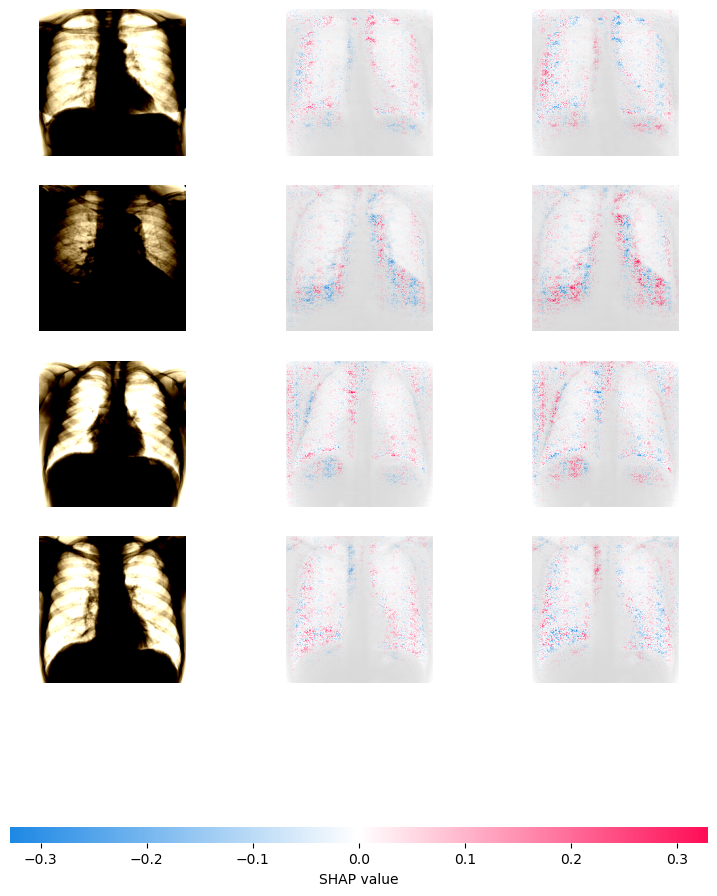

In [9]:
import shap
val_dataloader, val_dataset, val_class_names = get_loader(image_path,24,)
inputs, classes = next(iter(val_dataloader))
inputs, classes = inputs.cuda(), classes.cuda()
model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False)

background = inputs[0:16]
images = inputs[16:20]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(images)
#labels = np.vectorize(lambda x: classes.cpu().numpy()[str(x)])(indexes)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy )


#bcm = BinaryConfusionMatrix().to(device)
#inputs = inputs.to(device)
#classes = classes.to(device) 

#outputs=model(inputs)
#_, preds = torch.max(outputs, 1)
#results = bcm(preds, classes)
#results = results.cpu().numpy()

#create_cm(results, model_name)


In [ ]:
main() #VGG16

In [13]:
model_path = './tests/try_2/'
model_name = 'resnet_18'
batch_size = 24
#image_path = '../data/MIX_IMAGES_NEW/TRAIN/'
#image_path = VALIDATION_IMAGES
image_path = IMAGES
type_name = 'finetuning'
input_size = 224



In [19]:
val_dataloader, val_dataset, val_class_names = get_loader(image_path,60,)
inputs, classes = next(iter(val_dataloader))
inputs, classes = inputs.to(device), classes.to(device)
model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False)
model.eval()
bcm = BinaryConfusionMatrix().to(device)
inputs = inputs.to(device)
classes = classes.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
print(type(preds), type(classes))
results = bcm(preds, classes)
results = results.cpu().numpy()

create_cm(results, model_name)


<class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
def testBatch(model_path, image_path, batch_size, model_name, type_name, input_size, kfold=False):
    dataloader, dataset, class_names = get_loader(
        image_path, batch_size, input_size)


    model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False, kfold=kfold)
    accurate = 0
    bcm = BinaryConfusionMatrix().to(device)

    for inputs, labels in iter(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        if model_name == 'inception':
            outputs, aux_outputs = model(inputs)
        else:
            outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        accurate += torch.sum(preds == labels.data)
        #df = pd.DataFrame(columns=['File', 'Real', 'Pred'])
        #for j in range(batch_size):
        #    df = df.append([{'File': dataloader.dataset.samples[j][0],
        #                     'Real': class_names[labels[j]],
        #                     'Pred': class_names[preds[j]]}])
        print(bcm(preds, labels))

        #df.to_excel(f'{model_path}{model_name}_{type_name}_MC.xlsx', index=False)

    correct = accurate.cpu().data.numpy() / len(dataset) * 100
    print(f"Percentage of predictions: {correct: .2f} %")

In [ ]:
main() #densenet no weights finetune on

In [17]:
model_path = '/content/drive/MyDrive/Docs_Sebastian/models/tests'
model_name = 'densenet'
batch_size = 12
image_path = VALIDATION_IMAGES
type_name = 'finetuning'
input_size = 224



In [18]:
val_dataloader, val_dataset, val_class_names = get_loader(image_path,24,)
inputs, classes = next(iter(val_dataloader))
model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False)
bcm = BinaryConfusionMatrix().to(device)
inputs = inputs.to(device)
classes = classes.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
results = bcm(preds, classes)
results = results.cpu().numpy()

create_cm(results, model_name)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Docs_Sebastian/models/tests/densenet_finetuning.pth'

In [ ]:
main() #alexnet with no weights DONT

In [28]:
model_path = './tests/try_2/'
model_name = 'resnet_18'
batch_size = 12
VALIDATION_IMAGES = '../data/MIX_IMAGES_NEW/VALIDATION/'
image_path = VALIDATION_IMAGES
type_name = 'finetuning'
input_size = 224



In [29]:
val_dataloader, val_dataset, val_class_names = get_loader(image_path,24,)
inputs, classes = next(iter(val_dataloader))
model = set_models(model_name, model_path, type_name,
                       feture_extract=False, train=False)
bcm = BinaryConfusionMatrix().to(device)
inputs = inputs.to(device)
classes = classes.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
results = bcm(preds, classes)
results = results.cpu().numpy()

create_cm(results, model_name)
